In [1]:
!pip install torchsummary

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import PIL
from tqdm import tqdm
from torchsummary import summary

In [3]:
img_size=256
n_channels=1

latent_size=50
batch_size=64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

beta1 = 0.9
beta2 = 0.999

lr=0.001

num_workers=4

DATA_PATH = '...'
EPOCH_START=0
UPLOADED=False
LOAD_FILENAME_PATH = ('weights/vae_epoch_%d.pth' % EPOCH_START)

In [4]:
device

device(type='cuda')

In [5]:
dataset = dset.ImageFolder(root=DATA_PATH,
                           transform=transforms.Compose([
                               transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BICUBIC),
                               transforms.Grayscale(num_output_channels=1), #makes 1-channel image
                               transforms.ToTensor(),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

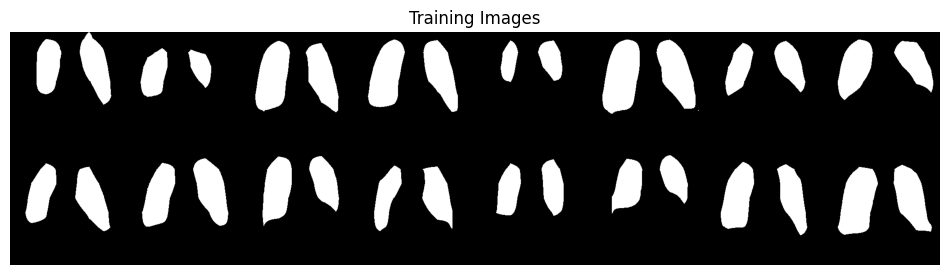

In [6]:
batch, _ = next(iter(dataloader))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(batch[:min(16,batch_size)].to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [7]:
batch[0].max(), batch[0].min()

(tensor(1.), tensor(0.))

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(4,8, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(8,16, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(16,32,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(32,64,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(64,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.AvgPool2d(2),
            #nn.Conv2d(256,256,kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
        )
        self.encoder_linear = nn.Linear(128*4*4, latent_size*2)
        self.decoder_linear = nn.Linear(latent_size, 128*4*4)
        self.flatten=nn.Flatten()
        self.unflatten=nn.Unflatten(1,(128,4,4))
        self.relu=nn.ReLU()
        self.decoder = nn.Sequential(
            #nn.Conv2d(256,256,kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,64,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64,32,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(32,16,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(16,8,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(8,4,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(4,1,kernel_size=3, stride=1,padding=1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x=self.flatten(x)
        x=self.encoder_linear(x).view(x.shape[0],2,-1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        
        return mu, logsigma#, idx
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        z=self.decoder_linear(z)
        z=self.relu(z)
        z=self.unflatten(z)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma=self.encode(x)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma))

        return reconstruction, mu, logsigma

In [9]:
model = VAE()
summary(model,(1,img_size,img_size), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 256, 256]              40
       BatchNorm2d-2          [-1, 4, 256, 256]               8
              ReLU-3          [-1, 4, 256, 256]               0
         AvgPool2d-4          [-1, 4, 128, 128]               0
            Conv2d-5          [-1, 8, 128, 128]             296
       BatchNorm2d-6          [-1, 8, 128, 128]              16
              ReLU-7          [-1, 8, 128, 128]               0
         AvgPool2d-8            [-1, 8, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           1,168
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
        AvgPool2d-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           4,640
      BatchNorm2d-14           [-1, 32,

In [10]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    #reconstruction.apply_(lambda a: (a+1.0)/2.0)
    #x.apply_(lambda a: (a+1.0)/2.0)
    loss = nn.BCELoss(reduction='sum')
    #return loss((reconstruction+1.0)/2.0, x)
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [11]:
def weights_init(m):
    def _weights_init(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            nn.init.normal_(module.weight, 0.0, 0.02)
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight, 1.0, 0.02)
            nn.init.constant_(module.bias, 0)
    
    return m.apply(_weights_init)

In [12]:
def show_sample(batch):
    fig = plt.figure(figsize=(12, 4))
    plt.axis("off")
    plt.title('Input->Generated')
    for i in range(2):
        for j in range(1,7):
            fig.add_subplot(2, 6, i*6+j)
            plt.imshow(np.transpose(batch[i][j-1],(1,2,0)), cmap='gray')
            plt.axis("off")
    plt.subplots_adjust(wspace=0.05,hspace=0)
    plt.show()

In [13]:
def fit(model, criterion, epochs, lr, epochs_start=0, uploaded=False):
    if epochs_start!=0 and not uploaded:
        model.load_state_dict(torch.load(LOAD_FILENAME_PATH))
        print('Model uploaded')
        
    model.to(device)
    model.train()
    torch.cuda.empty_cache()
    
    losses = []
    loss_per_batch = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
    lambda_log_likelihood = 1.0
    
    for epoch in tqdm(range(epochs)):
        if epoch == 400:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(beta1, beta2))
            lambda_log_likelihood = 0.1
            
        loss_per_epoch = []
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            optimizer.zero_grad()

            reconstruction, mu, logsigma = model(real_images)
            #cur_real_score = torch.mean(real_preds).item()
            loss = KL_divergence(mu, logsigma) + lambda_log_likelihood * log_likelihood(real_images, reconstruction)
            loss.backward()
            optimizer.step()
            
            loss_per_epoch.append(loss.item())
            loss_per_batch.append(loss.item())
            
            
            
        # logs
        losses.append(np.mean(loss_per_epoch))
        
        # logs
        print("Epoch [{}/{}], loss: {:.4f}".format(epoch+1+epochs_start, epochs+epochs_start, losses[-1]))

        # example
        show_sample(torch.stack((real_images,reconstruction)).detach().cpu())
        
        if (epoch+1+epochs_start)%50==0:
            torch.save(model.state_dict(),'vae_epoch_%d.pth' % (epoch+1+epochs_start))
            print('Model Saved! Epoch: %d' % (epoch+1+epochs_start))
            
    
    return losses, loss_per_batch

In [14]:
model = VAE()
model.apply(weights_init)
model.to(device)

lr=0.0001
epochs=600

In [ ]:
losses, loss_per_batch = fit(model, loss_vae, epochs, lr, EPOCH_START, UPLOADED)

In [16]:
with open('losses.txt', 'w') as f:
    for e in losses:
        f.write(str(e)+' ')

with open('loss_per_batch.txt', 'w') as f:
    for e in loss_per_batch:
        f.write(str(e)+' ')

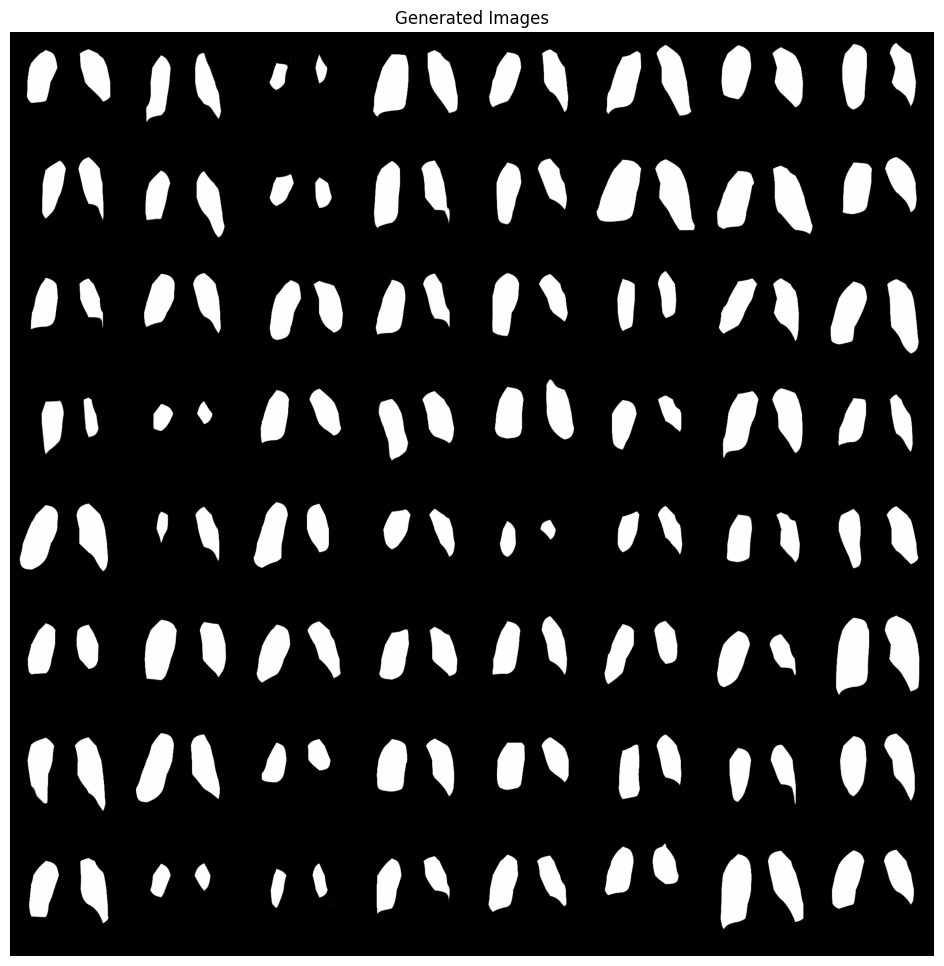

In [17]:
with torch.no_grad():
    model.eval()
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(64)])
    output = model.decode(torch.FloatTensor(z).to(device))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(output.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))